In [2]:
import numpy as np
import os
from skimage.measure import block_reduce
from scipy.misc import imread
import cPickle as pkl
import scipy.signal
import numpy.fft as fft
import sys
import optparse
from libtiff import TIFF
from PIL import Image
import re
import itertools
from scipy import ndimage

import math
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.cm as cm
import pandas as pd

%matplotlib inline


In [3]:
# outdir = '/media/juliana/TOSHIBA EXT/widefield/CE004/20160203/awake_circle_0013_REV/structs'
outdir = '/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/structs'

# outdir = '/media/nas/volume1/widefield/data/JR009/20150709/20150709_JR009_500um_05Hz_nored/structs' #V-Left ok
circle = True


reduceit = 0

if circle:
    CW = True #options.rev # CW IS REVERSE
    if CW:
        rev = True
    print "REV STATE: ", CW
    if rev=='False' and '_CW' in outdir:
        print "Fixing REV status [CW detected in fn]..."
        CW = True

    key = 'stimulus' #options.key
    
    rundir = os.path.split(outdir)[0]
    sessiondir = os.path.split(rundir)[0]
    
else:
    sessiondir = os.path.split(outdir)[0]
    

print sessiondir

REV STATE:  True
/media/nas/volume1/widefield/data/CE004/20160203


In [4]:
#################################################################################
# GET DATA STRUCT FILES:
#################################################################################

files = os.listdir(outdir)
files = [f for f in files if os.path.splitext(f)[1] == '.pkl']
dstructs = [f for f in files if 'Target_fft' in f]

print dstructs

D = dict()
for f in dstructs:
	outfile = os.path.join(outdir, f)
	with open(outfile,'rb') as fp:
		D[f] = pkl.load(fp)
print D.keys()


['Target_fft_stimulus_(1, 1)_nas.pkl', 'Target_fft_stimulus_(1, 1)_nas_DC.pkl', 'Target_fft_stimulus_(1, 1)_detrendfirst.pkl']
['Target_fft_stimulus_(1, 1)_nas_DC.pkl', 'Target_fft_stimulus_(1, 1)_nas.pkl', 'Target_fft_stimulus_(1, 1)_detrendfirst.pkl']


Current key:  Target_fft_stimulus_(1, 1)_nas_DC.pkl
Curr DIR:  /media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/structs


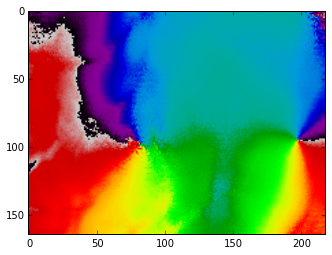

In [5]:
# Choose stimulus key:
if circle:
    if CW:
        cwkey = D.keys()[0]
        cwmap = D[cwkey]['ft']
        
    else:
        ccwkey = D.keys()[0]
        ccwmap = D[ccwkey]['ft']
    
    append = 'detrendfirst'
    
    
else:
    print "Choose key..."

    run_num = '0'
    reduce_factor = (2, 2)
    append = 'detrendfirst'
    cond_type = 'Down'

    run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]
    tmp_keys = [k for k in D.keys() if all([c in k for c in run_conds])] #[0]
    if len(tmp_keys) > 1:
        print "More than 1 match found: "
        print tmp_keys
    elif tmp_keys == []:
        print "No matches found from list: "
        print D.keys()
    else:
        if cond_type=='Left':
            leftkey = tmp_keys[0]
        elif cond_type=='Right':
            rightkey = tmp_keys[0]
        elif cond_type=='Down' or cond_type=='Top':
            topkey = tmp_keys[0]
        elif cond_type=='Up' or cond_type=='Bottom':
            bottomkey = tmp_keys[0]          
        

currkey = cwkey
currmap = D[currkey]['ft']


reduce_factor = (2, 2)
if reduce_factor[0] > 0:
	reduceit=1
else:
	reduceit=0
    
print "Current key: ", currkey
plt.imshow(np.angle(currmap), cmap='spectral')
print "Curr DIR: ", outdir

In [5]:
# ft = np.empty(D[cw_key]['mean_intensity'].shape)
# ft = ft + 0j

# for x in range(ft.shape[0]):
#     for y in range(ft.shape[1]):
#         ft[x, y] = complex(D[cw_key]['ft_real'][x][y], D[cw_key]['ft_imag'][x][y])

# D[cw_key]['ft'] = ft


/media/nas/volume1/widefield/data/CE004/20160203
['surface_20160203.tif']
.tif


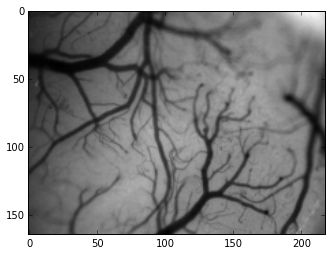

In [8]:
#################################################################################
# GET BLOOD VESSEL IMAGE:
#################################################################################

print sessiondir
folders = os.listdir(sessiondir)
figpath = [f for f in folders if f == 'figures']


if figpath:
    figdir = figpath[0]
    tmp_ims = os.listdir(os.path.join(sessiondir, figdir))
    surface_words = ['surface', 'GREEN', 'green', 'Surface']
    ims = [i for i in tmp_ims if any([word in i for word in surface_words])]
    print ims
    impath = os.path.join(sessiondir, figdir, ims[0])
    # image = Image.open(impath) #.convert('L')
    # imarray = np.asarray(image)
    print os.path.splitext(impath)[1]
    if os.path.splitext(impath)[1] == '.tif':
        tiff = TIFF.open(impath, mode='r')
        surface = tiff.read_image().astype('float')
        tiff.close()
        plt.imshow(surface)
    else:
        image = Image.open(impath) #.convert('L')
        surface = np.asarray(image)


else: # NO BLOOD VESSEL IMAGE...
    surface = np.zeros([200,300])

reduceit = 0
if reduceit:
    surface = block_reduce(surface, reduce_factor, func=np.mean)

plt.imshow(surface, cmap='gray')

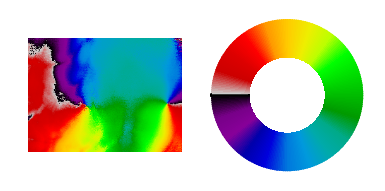

In [10]:
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(np.angle(currmap), cmap='spectral')
plt.axis('off')

if circle:
    ax = fig.add_subplot(1,2,2, projection='polar')
    ax.set_theta_zero_location('W') # W puts 0 on RIGHT side...

    ax._direction = 2*np.pi # object moves toward bottom first (CW)

    # ax._direction = -2*np.pi # objecct moves toward top first (CCW)

    norm = mpl.colors.Normalize(vmax=1*np.pi, vmin=-1*np.pi)
    #norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('spectral'),
                                    norm=norm, orientation='horizontal')
    # cb.ax.invert_xaxis()
    # cb.outline.set_visible(False)
    # ax.set_axis_off()
    ax.set_rlim([-1, 1])
    ax.axis('off')



<matplotlib.colorbar.Colorbar instance at 0x7fd2b1739680>

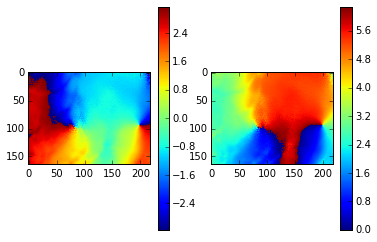

In [11]:

plt.subplot(1,2,1)
phase_map = np.angle(currmap)
plt.imshow(phase_map)
plt.colorbar()


plt.subplot(1,2,2)
shifted_phase_map = np.angle(currmap)
for x in range(shifted_phase_map.shape[0]):
    for y in range(shifted_phase_map.shape[1]):
        if shifted_phase_map[x,y] < 0:
            shifted_phase_map[x,y] += 2*math.pi
plt.imshow(shifted_phase_map)
plt.colorbar()


(164, 218)
(164, 218)
(164, 218)
/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/structs/SHIFT_overlayphase_CW_phase_map_detrendfirst.jpg


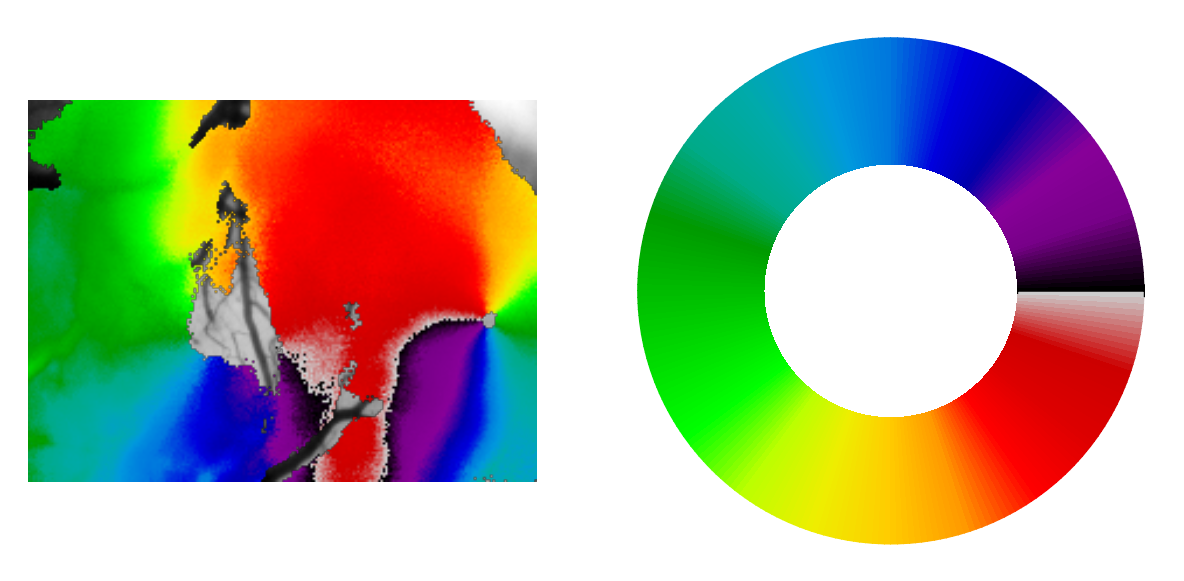

In [12]:
#SHIFTED:

fig = plt.figure(figsize=(20,10))

p = shifted_phase_map
print p.shape
# fig.add_subplot(1,2,1)
# plt.imshow(p, cmap='spectral')
# plt.axis('off')
# # plt.colorbar()  # Just make sure goes from 0 to 2pi now...l

use_mean_intensity = 0 # set to 1 if want to threshold with mean intensity values instead of magnitude
use_log = 1
threshold = 0.30
Ny = len(D[currkey]['freqs'])/2.
mag_map = D[currkey]['mag_map']/Ny
print mag_map.shape
# phase_map = D[curr_key]['phase_map']

#-----------------------------------------------------------------
# Overlaid Phase-map, thresholded
#-----------------------------------------------------------------

fig = plt.figure(figsize=(20,10))

fig.add_subplot(1,2,1)
plt.imshow(surface,cmap=cm.Greys_r)
print surface.shape

if use_mean_intensity:
    mean_intensity = D[currkey]['mean_intensity']
    [x, y] = np.where(mean_intensity >= threshold*mean_intensity.max())
    phase_mask = np.ones(mean_intensity.shape) * 100
    # phase_mask[x, y] = phase_map[x, y]
    phase_mask[x, y] = p[x, y] #D[curr_key]['phase_map'][x, y]
    tit = 'Threshold, %.2f of mean intensity max' % (threshold)

else:
    if use_log:
        [x, y] = np.where(np.log(mag_map) >= threshold * np.log(mag_map.max()))
    else:
        [x, y] = np.where(mag_map >= threshold * mag_map.max())
    phase_mask = np.ones(mag_map.shape) * 100
    phase_mask[x, y] = p[x,y] #phase_map[x, y]
    tit = 'Threshold, %.2f of log max magnitude' % (threshold)

[nullx, nully] = np.where(phase_mask == 100)
phase_mask[nullx, nully] = np.nan
phase_mask = np.ma.array(phase_mask)
plt.imshow(phase_mask, cmap='spectral', vmin=0*math.pi, vmax=2*math.pi)
plt.axis('off')




# ADDL  shifted color wheeL


if circle:
#     fig = plt.figure()
    ax = fig.add_subplot(1,2,2, projection='polar')
    ax.set_theta_zero_location('E') # W puts 0 on RIGHT side... need to flip around to EAST for shifted wheel

    ax._direction = 2*np.pi # object moves toward bottom first (CW)

    # ax._direction = -2*np.pi # objecct moves toward top first (CCW)

    norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0*np.pi)
    #norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('spectral'),
                                    norm=norm, orientation='horizontal')
    # cb.ax.invert_xaxis()
    # cb.outline.set_visible(False)
    # ax.set_axis_off()
    ax.set_rlim([-1, 1])
    ax.axis('off')

if circle:
    if CW:
        imname = 'SHIFT_overlayphase_CW_phase_map_%s' % (append)
    else:
        imname = 'SHIFT_overlayphase_CCW_phase_map_%s' % (append)

impath = os.path.join(outdir, imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath

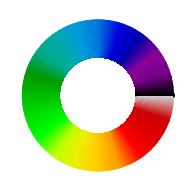

In [13]:
if circle:
    fig = plt.figure()
    ax = fig.add_subplot(1,2,2, projection='polar')
    ax.set_theta_zero_location('E') # W puts 0 on RIGHT side...

    ax._direction = 2*np.pi # object moves toward bottom first (CW)

    # ax._direction = -2*np.pi # objecct moves toward top first (CCW)

    norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0*np.pi)
    #norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('spectral'),
                                    norm=norm, orientation='horizontal')
    # cb.ax.invert_xaxis()
    # cb.outline.set_visible(False)
    # ax.set_axis_off()
    ax.set_rlim([-1, 1])
    ax.axis('off')


164


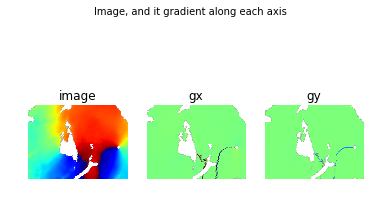

In [14]:
# p = np.flipud(shifted_phase_map)
# p = shifted_phase_map


p = phase_mask


# plt.imshow(p)
gy, gx = np.gradient(p)
print len(gy)
# print "gx =", gx
# print "gy =", gy

# plotting
plt.close("all")
plt.figure()
plt.suptitle("Image, and it gradient along each axis")
ax = plt.subplot("131")
ax.axis("off")
ax.imshow(p)
ax.set_title("image")

ax = plt.subplot("132")
ax.axis("off")
ax.imshow(gx)
ax.set_title("gx")

ax = plt.subplot("133")
ax.axis("off")
ax.imshow(gy)
ax.set_title("gy")
plt.show()


/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/figures/GRADIENT_phase_mask_CW_Target_fft_stimulus_(1, 1)_nas_DC.pkl_<function append at 0x7f9b7cfbd6e0>.jpg


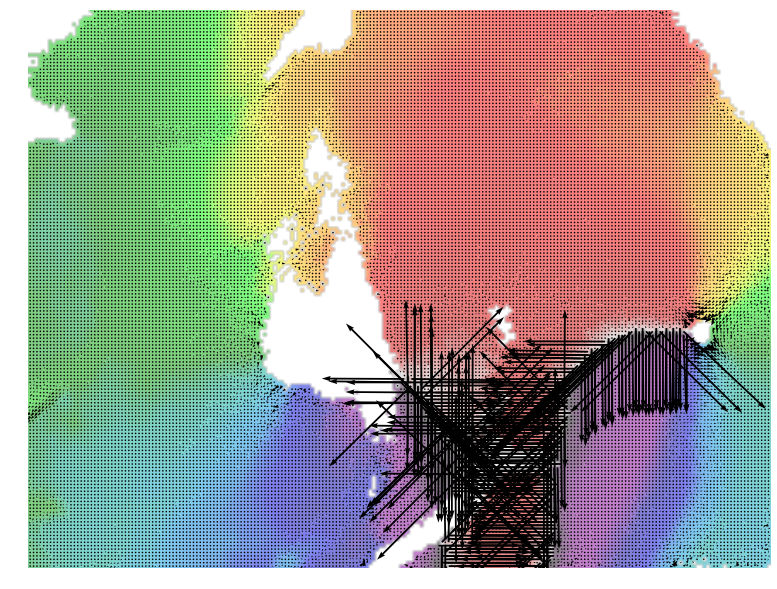

In [21]:
from pylab import *

# plt.subplot(1,2,1)
fig = plt.figure(figsize=(20,10))

plt.imshow(p, cmap='spectral', alpha=0.5)

widths = np.linspace(0, .1, 218)

# plt.subplot(1,2,1)
Q = quiver(gx, gy)


# plt.subplot(1,2,2)
# Q = quiver(gx, gy)


# l,r,b,t = axis()
# dx, dy = r-l, t-b
# axis([l-0.05*dx, r+0.05*dx, b-0.05*dy, t+0.05*dy])

plt.axis('off')

# plt.colorbar()

if CW:
    imname = 'GRADIENT_phase_mask_CW_%s_%s' % (currkey, append)
else:
    imname = 'GRADIENT_phase_mask_CCW_%s_%s' % (currkey, append)
    
impath = os.path.join(os.path.split(outdir)[0], 'figures', imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(os.path.split(outdir)[0], 'figures', imname+'.jpg')
plt.savefig(impath, format='jpg')


print impath

# figpath = os.path.join(os.path.split(outdir)[0], 'figures', 'phase_gradient_%s.jpg' % currkey)
# plt.savefig(figpath)
# print figpath

 ...]

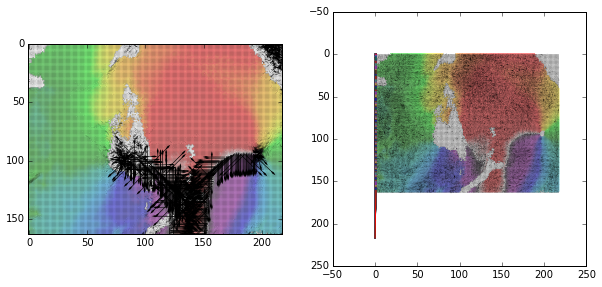

In [66]:

def symlog(x):
    """ Returns the symmetric log10 value """
    return np.sign(x) * np.log10(np.abs(x))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

# Generate fake data
# N = 50
# X,Y = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))
# U = np.random.normal(0, 0.2, size=(50, 50))
# V = np.random.normal(0, 0.2, size=(50, 50))

# N = len(gx)

X, Y = np.meshgrid(np.arange(0, p.shape[0], 1), np.arange(0, p.shape[1], 1))
Z = shifted_phase_map[X, Y] ##x * np.exp(-x**2 - y**2)

V, U = np.gradient(Z, 1, 1) # .2, .2)

# V, U = np.gradient(p)

N = len(V)

# Set RHS data to be larger than LHS
# U[:, N/2:] *= 1000
# V[:, N/2:] *= 1000

angles=np.arctan2(U, V)*180.0/np.pi # calculate angles manually

# #Without scaling
HEAD_LENGTH = 10
# Q = ax1.quiver( X[::3, ::3], Y[::3, ::3], U[::3, ::3], V[::3, ::3],
#              color='k', units='x', headaxislength=HEAD_LENGTH)
ax1.imshow(p, cmap='spectral', alpha=0.5)

# Q = ax1.quiver( X, Y, U, V,
#              color='k', units='x', headaxislength=HEAD_LENGTH)
Q = ax1.quiver( Y, X, V, U,
             color='k', units='x', headaxislength=HEAD_LENGTH)



# With scaling
# Q = ax2.quiver( X[::3, ::3], Y[::3, ::3], symlog(U[::3, ::3]), symlog(V[::3, ::3]),
#              color='k', units='x', headaxislength=HEAD_LENGTH, angles=angles)

ax2.imshow(p, cmap='spectral', alpha=0.5)
# Q = ax2.quiver( X, Y, symlog(U), symlog(V),
#              color='k', units='x', headaxislength=HEAD_LENGTH, angles=angles)
Q = ax2.quiver( Y, X, symlog(V), symlog(U),
             color='k', units='x', headaxislength=HEAD_LENGTH, angles=angles)

neg = np.where(U<0)

plt.plot(neg)
# plt.show()

(218, 164)
(218, 164)


/home/juliana/anaconda/envs/retinodev/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


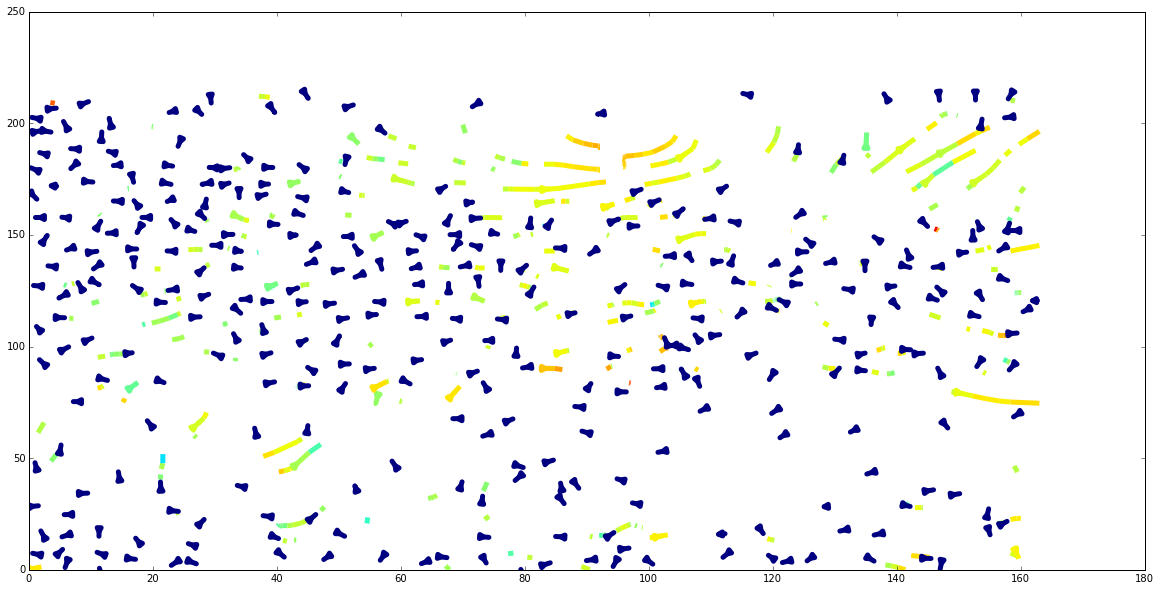

In [65]:
fig = plt.figure(figsize=(10,10))

# plt.imshow(p, cmap='spectral', alpha=0.5)
# Q = ax2.quiver( X, Y, symlog(U), symlog(V),
#              color='k', units='x', headaxislength=HEAD_LENGTH, angles=angles)

# Q = plt.quiver( Y, X, symlog(V), symlog(U),
#              color='k', units='x', headaxislength=HEAD_LENGTH, angles=angles)

print angles.shape

LOG = np.empty(V.shape)
print symlog(V).shape
for x in range(V.shape[0]):
    for y in range(V.shape[1]):
#         if symlog(V[x,y]) < 0:
#             LOG[x, y] = 0
#         if symlog(V[x,y]) > 0:
#             LOG[x, y] = 1
        if angles[x,y] < 0:
            LOG[x, y] = 0
        if angles[x,y] > 0:
            LOG[x, y] = 1
            
# plt.imshow(angles)

fig, ax = plt.subplots(figsize=(20,10))
ax = plt.subplot(111)

# strm = ax.streamplot(X, Y, U, V, density=0.6, color=angles, linewidth=5) #=lw*10)
# strm = ax.streamplot(X, Y, U, V, density=[0.5, 1])
strm = ax.streamplot(X, Y, U, V, color=np.log10(U), linewidth=5)

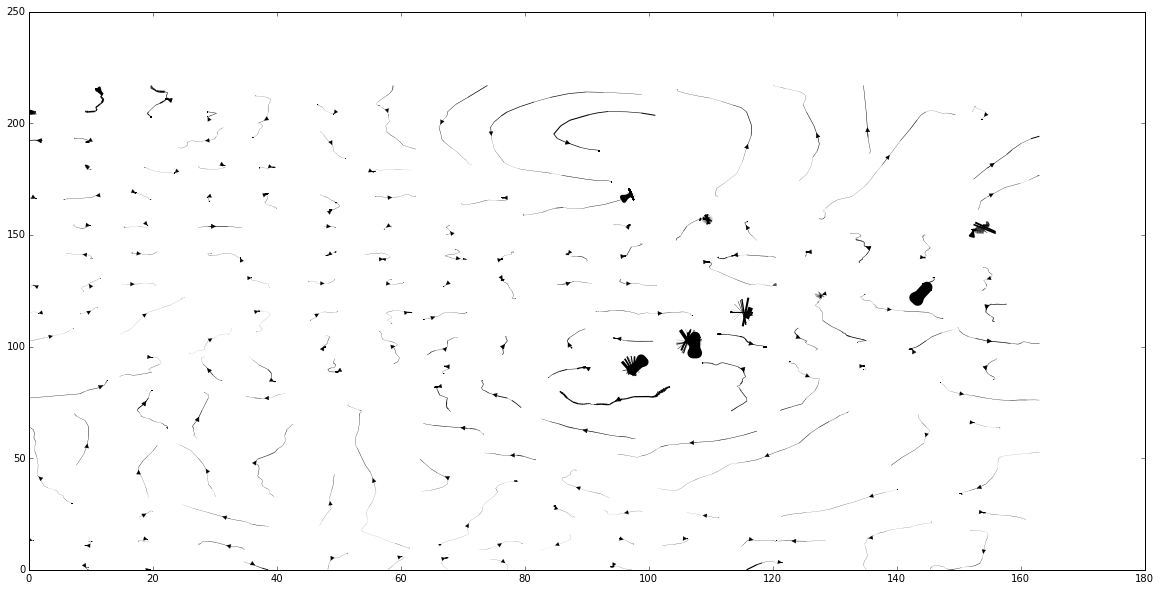

In [20]:
"""
Demo of the `streamplot` function.

A streamplot, or streamline plot, is used to display 2D vector fields. This
example shows a few features of the stream plot function:

    * Varying the color along a streamline.
    * Varying the density of streamlines.
    * Varying the line width along a stream line.
"""
import numpy as np
import matplotlib.pyplot as plt


# p = shifted_phase_map

p = phase_mask

# Y, X = np.meshgrid(np.arange(0, p.shape[0], 1), np.arange(0, p.shape[1], 1))

X, Y = np.meshgrid(np.arange(0, p.shape[0], 1), np.arange(0, p.shape[1], 1))
Z = shifted_phase_map[X, Y] ##x * np.exp(-x**2 - y**2)

V, U = np.gradient(Z, 1, 1) # .2, .2)


# Y, X = np.mgrid[-3:3:100j, -3:3:100j]
# U = -1 - X**2 + Y
# V = 1 + X - Y**2

speed = np.sqrt(U*U + V*V)

fig, ax = plt.subplots(figsize=(20,10))
ax = plt.subplot(111)
# # strm = ax.streamplot(X, Y, U, V, color=U, linewidth=2, cmap=plt.cm.spectral)
# strm = ax.streamplot(X, Y, U, V, color=U, linewidth=2, cmap=plt.cm.spectral)

# plt.colorbar(strm.lines)

# fig1, (ax1, ax2) = plt.subplots(ncols=2)
# ax1.streamplot(X, Y, U, V, density=[0.5, 1])

lw = 5*speed / speed.max()
strm = ax.streamplot(X, Y, U, V, density=0.6, color='k', linewidth=lw*10)

# plt.colorbar(strm.lines)

# plt.show()


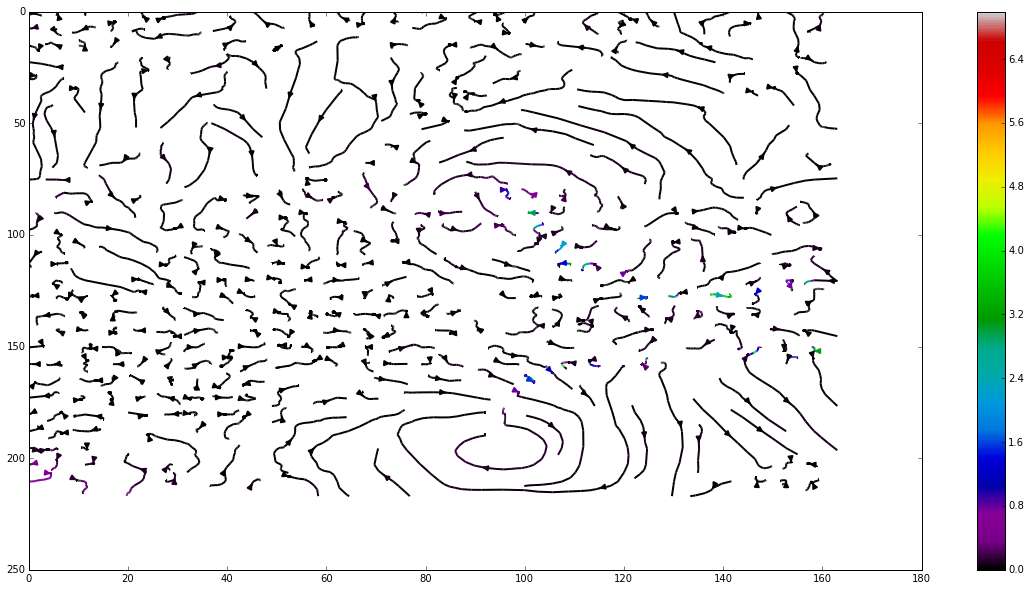

In [76]:

# fig = plt.figure(figsize=(20,10))
speed = np.sqrt(U*U + V*V)

M = (U ** 2 + V ** 2) ** 0.5

fig0, ax0 = plt.subplots(figsize=(20,10))
strm = ax0.streamplot(X, Y, U, V, color=speed, linewidth=2, cmap=plt.cm.spectral, )
fig0.colorbar(strm.lines)

# fig1, (ax1, ax2) = plt.subplots(ncols=2)
# ax1.streamplot(X, Y, U, V, density=[0.5, 1])

# lw = 5*speed / speed.max()
# ax2.streamplot(X, Y, U, V, density=0.6, color='k', linewidth=lw)
plt.gca().invert_yaxis()

plt.show()


In [24]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.offline import plot

# x, y = np.meshgrid(np.linspace(0, len(gx), len(gx)), np.linspace(0, len(gy), len(gy)))
x,y = np.meshgrid(np.arange(0, p.shape[0], 1), np.arange(0, p.shape[1], 1))
z = p[x, y] ##x * np.exp(-x**2 - y**2)

v, u = np.gradient(z, 1, 1) # .2, .2)

# x,y = np.meshgrid(np.arange(0, p.shape[0], 1), np.arange(0, p.shape[1], 1))
# x = range(p.shape[0])
# y = range(p.shape[0])

# u = gx #np.cos(x)*y
# v = gy #np.sin(x)*y

# v, u = np.gradient(p)

print len(y), len(v)

# Create quiver
# fig = FF.create_quiver(x, y, u, v)

# # Create quiver figure
# fig = FF.create_quiver(x, y, u, v,
#                        scale=.25,
#                        arrow_scale=.4,
#                        name='quiver',
#                        line=dict(width=1))


# plot(fig, filename='quiver plot')


218 218


In [ ]:
# Create quiver figure
fig = FF.create_quiver(y, x, u, v)
#                        scale=.25,
#                        arrow_scale=.4,
#                        name='quiver',
#                        line=dict(width=1))


iplot(fig, filename='quiver plot')

<matplotlib.colorbar.Colorbar instance at 0x7effbd1004d0>

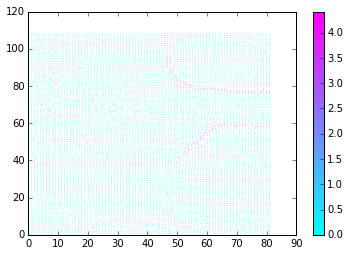

In [59]:
length  = np.sqrt(u**2 + v**2)
 
un = u/length
vn = v/length
 
plt.figure()
plt.quiver(x, y, un, vn,
          length,
          cmap = plt.cm.spectral,
          headlength = 20)
plt.colorbar()
# plt.axis([-1, 7, -1, 7])
# plt.title("scales with x view; pivot='tip'")

In [ ]:
import plotly.graph_objs as go

data = [
    go.Heatmap(
        
        z=shifted_phase_map
    )
]

plot_url = plot(data, filename='heatmap-test')


# plot(fig, filename='quiver plot')